In [1]:
import pandas as pd
import numpy as np
from glob import glob
import warnings
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import sys
sys.path.append('src')
from src.swe_retrievals import phase_from_soil_moisture

warnings.simplefilter('ignore', FutureWarning)

NameError: name 'Lambda' is not defined

## Soil functions

/var/folders/qw/0hrz2r9d1hgffvdv588xr_9r0000gp/T/ipykernel_34616/2791759137.py:85: RuntimeWarning: invalid value encountered in scalar divide
  return 1/(2*1j * kz1 - 2* 1j * np.conj(kz2))


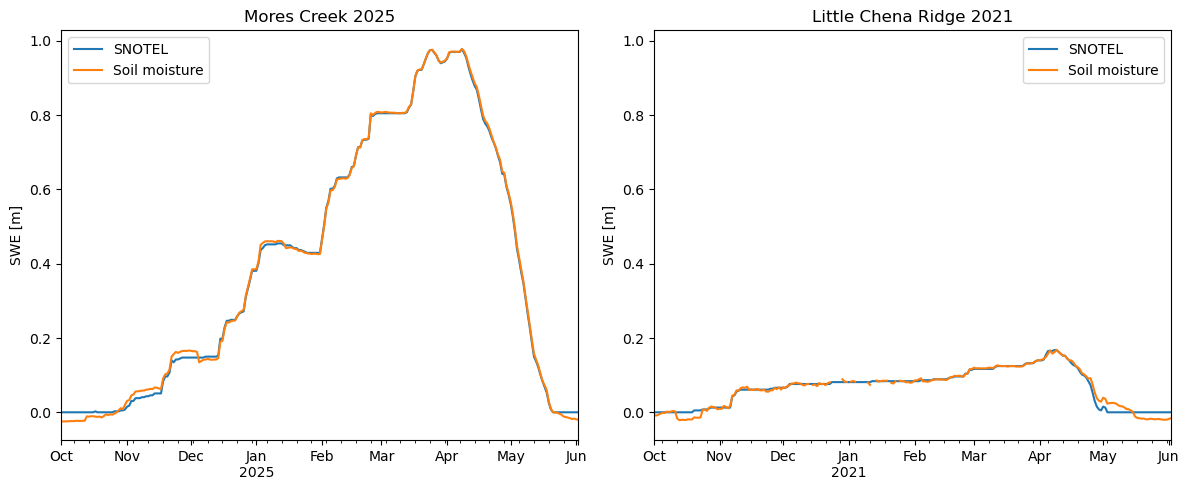

In [204]:
mores = pd.read_csv('../data_sandbox/swe_errors/637_ALL_WATERYEAR=2025.csv', header=1, 
                    index_col='Date', parse_dates=[1], na_values=[-99.9]).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct)  (silt)':'sm_2cm'})
mores.drop(columns=['Site Id','Time'], inplace=True)
mores['swe'] *= 0.0254

chena = pd.read_csv('../data_sandbox/swe_errors/947_ALL_WATERYEAR=2021.csv', header=1, 
                    index_col='Date', parse_dates=[1], na_values=[-99.9]).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct) ':'sm_2cm'})
chena.drop(columns=['Site Id','Time'], inplace=True)
chena['swe'] *= 0.0254
chena = chena.loc[:'2021-06-02']

mores_12day = mores.diff(periods=12)['sm_2cm']/100
chena_12day = chena.diff(periods=12)['sm_2cm']/100

mores_sand = 45.1
mores_clay = 14.4
mores['soil_error'] = calc_soil_moisture_error(mores_sand, mores_clay, mores['sm_2cm']/100) + mores['swe']


chena_sand = 31.2
chena_clay = 11.8
chena['soil_error'] = calc_soil_moisture_error(chena_sand, chena_clay, chena['sm_2cm']/100) + chena['swe']




# mores_soil_phase = np.array([vectorize_soils(sand=45.1, clay=14.4, sm=sm) for sm in mores_12day]).flatten()

fig, ax = plt.subplots(1, 2, figsize=(12,5))
mores['swe'].plot(ax=ax[0], label='SNOTEL')
mores['soil_error'].plot(ax=ax[0], label='Soil moisture')
ax[0].set_title('Mores Creek 2025')
ax[0].set_xlabel('')
ax[0].set_ylabel('SWE [m]')
ax[0].legend()

chena['swe'].plot(ax=ax[1], label='SNOTEL')
chena['soil_error'].plot(ax=ax[1], label='Soil moisture')
ax[1].set_title('Little Chena Ridge 2021')
ax[1].set_xlabel('')
ax[1].set_ylabel('SWE [m]')
ax[1].set_ylim(ax[0].get_ylim())
ax[1].legend()

plt.tight_layout()


# for axx in ax.flatten():
#     axx.set_ylim([-0.02, 1.02])

<Axes: xlabel='Date'>

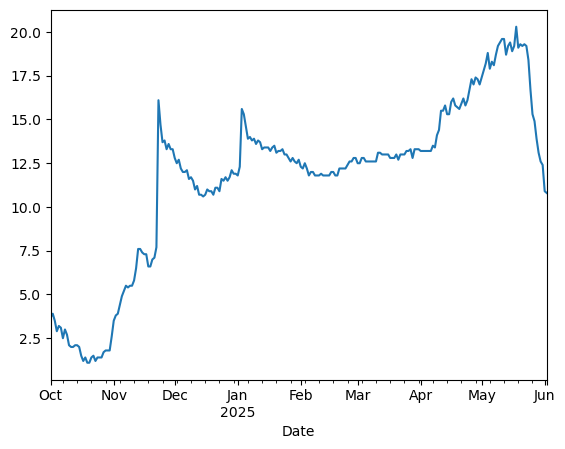

In [ ]:
hour

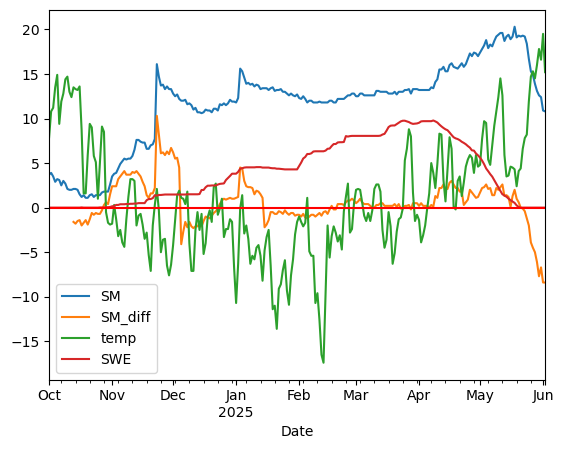

In [142]:
mores['sm_2cm'].plot(label='SM')
mores_12day.plot(label='SM_diff')
mores['TAVG.D-1 (degC) '].plot(label='temp')
(mores['swe']*10).plot(label='SWE')
plt.axhline(0, color='red')
plt.legend()

In [ ]:
mores_files = sorted(glob('../data_sandbox/swe_errors/snotel/hourly/637*.csv'))
mores = pd.read_csv(mores_files[0], header=1, parse_dates=[[1,2]], na_values=['-99.9'])
mores.index = mores['Date_Time']
mores.drop(columns=['Date_Time', 'Site Id'], inplace=True)

for f in mores_files[1:]:
    df_tmp = pd.read_csv(f, header=1, parse_dates=[[1,2]], na_values=['-99.9'])
    df_tmp.index = df_tmp['Date_Time']
    df_tmp.drop(columns=['Date_Time', 'Site Id'], inplace=True)
    mores = pd.concat([mores, df_tmp])

mores['WaterYear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in mores.index]
mores = mores[[c for c in mores.columns if 'Unnamed' not in c]]


chena_files = sorted(glob('../data_sandbox/swe_errors/snotel/hourly/947*.csv'))
chena = pd.read_csv(chena_files[0], header=1, parse_dates=[[1,2]], na_values=['-99.9'])
chena.index = chena['Date_Time']
chena.drop(columns=['Date_Time', 'Site Id'], inplace=True)

for f in chena_files[1:]:
    df_tmp = pd.read_csv(f, header=1, parse_dates=[[1,2]], na_values=['-99.9'])
    df_tmp.index = df_tmp['Date_Time']
    df_tmp.drop(columns=['Date_Time', 'Site Id'], inplace=True)
    chena = pd.concat([chena, df_tmp])

chena['WaterYear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in chena.index]
chena = chena[[c for c in chena.columns if 'Unnamed' not in c]]



# fig, ax = plt.subplots()
# for year in df['WaterYear'].unique():
#     data = df.loc[df['WaterYear']==year,'WTEQ.I-1 (in) '].reset_index()
#     data.loc[data['WTEQ.I-1 (in) ']==-99.9, 'WTEQ.I-1 (in) '] = np.nan
#     data['WTEQ.I-1 (in) '].plot(ax=ax, label=year)
# ax.legend() 
    


In [213]:
chena.columns

Index(['WTEQ.I-1 (in) ', 'PREC.I-1 (in) ', 'PREC.I-2 (in) ',
       'TOBS.I-1 (degC) ', 'SNWD.I-1 (in) ', 'SMS.I-1:-2 (pct) ',
       'SMS.I-1:-8 (pct) ', 'SMS.I-1:-20 (pct) ', 'STO.I-1:0 (degC) ',
       'STO.I-1:-2 (degC) ', 'STO.I-1:-8 (degC) ', 'STO.I-1:-20 (degC) ',
       'BATT.I-1 (volt) ', 'WDIRV.H-1 (degr) ', 'WSPDX.H-1 (mph) ',
       'WSPDV.H-1 (mph) ', 'SRADV.H-1 (watt) ', 'PRES.I-1 (mbar) ',
       'DIAG.I-1 (unit) ', 'DIAG.I-2 (unit) ', 'DIAG.I-3 (unit) ',
       'DIAG.I-4 (unit) ', 'DIAG.I-5 (unit) ', 'DIAG.I-6 (unit) ',
       'WaterYear'],
      dtype='object')